In [1]:
import pickle
import glob
import os
from tqdm import tqdm
import numpy as np
from collections import Counter
import torch
import json

def get_frequency_map_unique(arr):
    result = Counter(tuple(sorted(set(row))) for row in arr)
    return result

ds = 'pascal_ctx'
num_classes = 59

def get_freq_map_from_dir(ds):
    exp = 'fluctuations'
    exp_dir = f'/BS/mlcysec2/work/hierarchical-certification/log/{ds}/{exp}'
    hierarchy = f'/BS/mlcysec2/work/hierarchical-certification/HRNet-Semantic-Segmentation/data/{ds}/{ds}_hierarchy.json'
    hierarchy = json.load(open(hierarchy, 'r'))
    train_id_to_cls_name = {}
    for node in hierarchy['nodes']:
        if node['level'] == 0:
            train_id_to_cls_name[node['train_id']] = node['name']
    def transform_to_names(k):
        k_ = []
        for i in k:
            k_.append(train_id_to_cls_name[i])
        return tuple(k_)
    freq_map = {}
    for file in tqdm(glob.glob(os.path.join(exp_dir, '*.pkl'))[:30], desc=f'reading from {exp_dir}'):
        d = pickle.load(open(file, 'rb'))
        filename = os.path.basename(file).replace('.pkl', '')
        new_d = {}
        new_d[filename] = d[filename]
        d = new_d
        for image_name, image_d in d.items():
            for model_type, model_d in image_d.items():
                for metric, value in model_d.items():
                    if metric == 'fluctuations':
                        f = model_d['fluctuations']
                        if isinstance(f, torch.Tensor):
                            f = f.numpy()
                        f_map = get_frequency_map_unique(f.T)
                        for k, v in f_map.items():
                            k = transform_to_names(k)
                            if k not in freq_map:
                                freq_map[k] = 0
                            freq_map[k] += v
    return freq_map
freq_map = {}
for ds in [ 'cityscapes', 'acdc', 'cocostuff', 'pascal_ctx',]:
    freq_map[ds] = get_freq_map_from_dir(ds)

/BS/mlcysec2/work/anaconda3/envs/hrnet/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
reading from /BS/mlcysec2/work/hierarchical-certification/log/cityscapes/fluctuations: 100%|██████████| 30/30 [00:56<00:00,  1.89s/it]
reading from /BS/mlcysec2/work/hierarchical-certification/log/acdc/fluctuations: 100%|██████████| 30/30 [02:36<00:00,  5.22s/it]
reading from /BS/mlcysec2/work/hierarchical-certification/log/cocostuff/fluctuations: 100%|██████████| 30/30 [00:27<00:00,  1.08it/s]
reading from /BS/mlcysec2/work/hierarchical-certification/log/pascal_ctx/fluctuations: 100%|██████████| 30/30 [00:23<00:00,  1.26it/s]


In [2]:
def custom_format(value, _):
    exp = int(np.log10(value))
    base = int(value / 10**exp)
    return f"{base} x 10^{exp}"

/BS/mlcysec2/work/tmp/ipykernel_1638480/1451541273.py:26: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axes[colx].set_ylim(0, 460000)


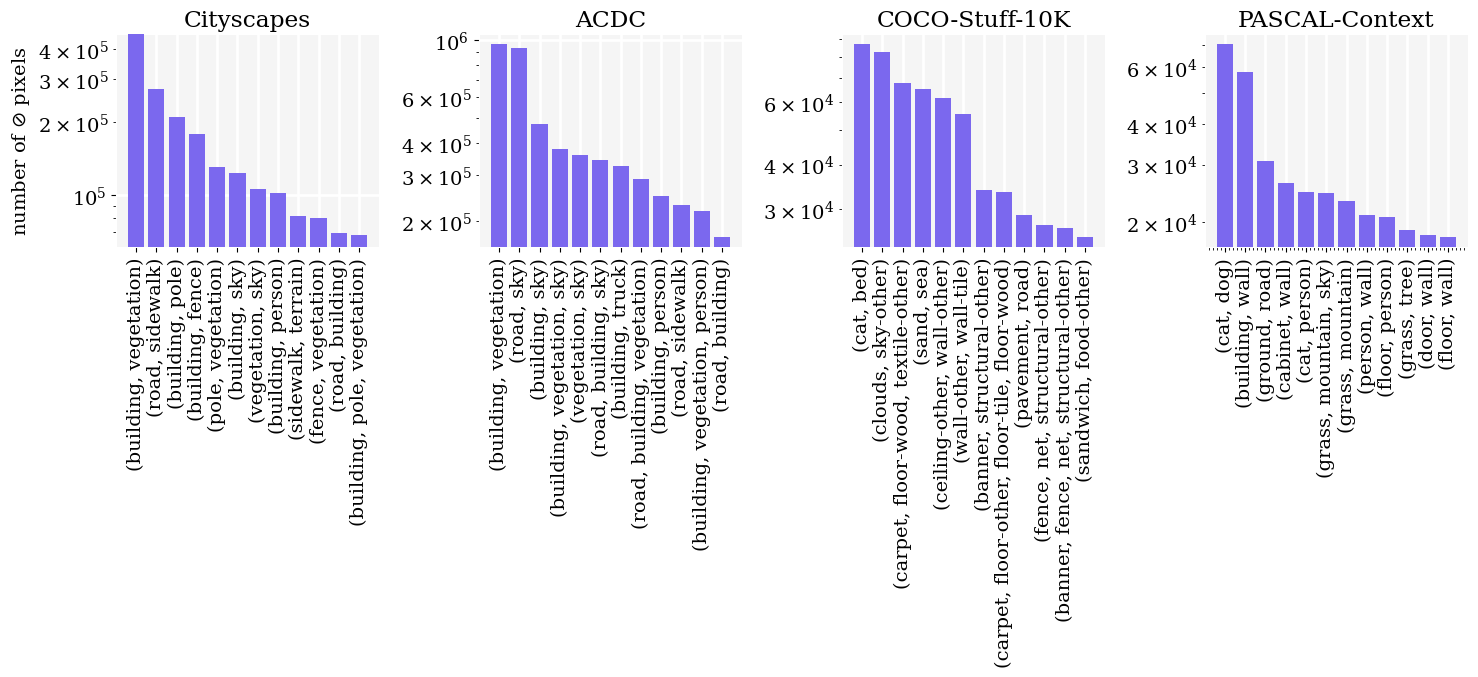

In [4]:
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
from matplotlib.ticker import LogLocator, FuncFormatter, MaxNLocator

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)
fig, axes = plt.subplots(1, 4, figsize=(15,7), sharey=False)
plt.minorticks_on()
colx = 0
top_k = 12
ds_formal = {'pascal_ctx': 'PASCAL-Context', 'cocostuff': 'COCO-Stuff-10K', 'cityscapes':'Cityscapes', 'acdc':'ACDC'}
for ds, ds_freq_map in freq_map.items():
        if ds_freq_map is not None:
                ds_freq_map = dict(sorted(ds_freq_map.items(), key=lambda item: item[1], reverse=True))
                x = [str(x_).replace("'", '').strip() for x_ in ds_freq_map.keys()][:top_k]
                y = [y_ for y_ in list(ds_freq_map.values())][:top_k]
                axes[colx].bar(x, y, zorder=3, color='mediumslateblue')
                axes[colx].tick_params(axis='x', rotation=90)
                axes[colx].set_yscale('log')
                # style
                if ds == 'cityscapes':
                        axes[colx].set_ylim(0, 460000)
                axes[colx].grid(color = 'white', linestyle = '-', linewidth = 2, alpha=1, zorder=0)
                plt.setp(axes[colx].spines.values(), color='white')
                axes[colx].set_facecolor('whitesmoke')
                axes[colx].set_title(ds_formal[ds])
        colx+=1
axes[0].set_ylabel(r'number of $\oslash$ pixels')
# Setting a custom formatter for y-ticks
plt.tight_layout()
plt.show()

fig.savefig('/BS/mlcysec2/work/hierarchical-certification/graph_images/fluctuations.pdf')
